# Mercedes-Benz Greener Manufacturing

## Description
Since the first automobile, the Benz Patent Motor Car in 1886, Mercedes-Benz has stood for important automotive innovations. These include, for example, the passenger safety cell with crumple zone, the airbag and intelligent assistance systems. Mercedes-Benz applies for nearly 2000 patents per year, making the brand the European leader among premium car makers. Daimler’s Mercedes-Benz cars are leaders in the premium car industry. With a huge selection of features and options, customers can choose the customized Mercedes-Benz of their dreams. .

To ensure the safety and reliability of each and every unique car configuration before they hit the road, Daimler’s engineers have developed a robust testing system. But, optimizing the speed of their testing system for so many possible feature combinations is complex and time-consuming without a powerful algorithmic approach. As one of the world’s biggest manufacturers of premium cars, safety and efficiency are paramount on Daimler’s production lines.

## Dataset Description
- This dataset contains an anonymized set of variables, each representing a custom feature in a Mercedes car. For example, a variable could be 4WD, added air suspension, or a head-up display. 

- The ground truth is labeled ‘y’ and represents the time (in seconds) that the car took to pass testing for each variable.

## File descriptions
* Variables with letters are categorical. Variables with 0/1 are binary values.
* train.csv - the training set
* test.csv - the test set, you must predict the 'y' variable for the 'ID's in this file
* sample_submission.csv - a sample submission file in the correct format

## Citation
Alexander Novy, CH1Mercedes, Christian Drescher, Christian Pfaundler, KOESIM, Will Cukierski. (2017). Mercedes-Benz Greener Manufacturing. Kaggle. 

https://kaggle.com/competitions/mercedes-benz-greener-manufacturing


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import keras.backend as K
import itertools

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.decomposition import PCA

In [2]:
def categorical_to_onehot_lookups(categorical_features_array):
    lookup_layers = []

    for i in range(categorical_features_array.shape[1]):
        lookup = tf.keras.layers.StringLookup(output_mode='one_hot')
        np_to_tensor = tf.convert_to_tensor(categorical_features_array[:, i])
        lookup.adapt(np_to_tensor)
        lookup_layers.append(lookup)
        del lookup # safety purpose

    return lookup_layers 

In [3]:
def lookups_for_one_hot(categorical_features_array, lookup_layers):

    list_values=[]
    for i in range(categorical_features_array.shape[1]):
        lookup = lookup_layers[i]
        np_to_tensor = tf.convert_to_tensor(categorical_features_array[:, i])
        onehot_encoded = lookup(np_to_tensor)
        list_values.append(onehot_encoded)

    return tf.concat(list_values, axis=1)

In [4]:
df = pd.read_csv("train/train.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB


In [6]:
# Object dtype cols
df.select_dtypes(include='object')

,X0,X1,X2,X3,X4,X5,X6,X8
0,k,v,at,a,d,u,j,o
1,k,t,av,e,d,y,l,o
2,az,w,n,c,d,x,j,x
3,az,t,n,f,d,x,l,e
4,az,v,n,f,d,h,d,n
...,...,...,...,...,...,...,...,...
4204,ak,s,as,c,d,aa,d,q
4205,j,o,t,d,d,aa,h,h
4206,ak,v,r,a,d,aa,g,e
4207,al,r,e,f,d,aa,l,u


In [7]:
df.describe()

,ID,y,X10,X11,X12,X13,X14,X15,X16,X17,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
count,4209.000000,4209.000000,4209.000000,4209.0,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,...,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000
mean,4205.960798,100.669318,0.013305,0.0,0.075077,0.057971,0.428130,0.000475,0.002613,0.007603,...,0.318841,0.057258,0.314802,0.020670,0.009503,0.008078,0.007603,0.001663,0.000475,0.001426
std,2437.608688,12.679381,0.114590,0.0,0.263547,0.233716,0.494867,0.021796,0.051061,0.086872,...,0.466082,0.232363,0.464492,0.142294,0.097033,0.089524,0.086872,0.040752,0.021796,0.037734
min,0.000000,72.110000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2095.000000,90.820000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4220.000000,99.150000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6314.000000,109.010000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8417.000000,265.320000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
df.columns = [col.lower() for col in df]

In [9]:
df.drop("id", axis=1, inplace=True)

In [10]:
df = df[df.select_dtypes(include="object").columns.to_list() + df.select_dtypes(exclude="object").columns.to_list()]
df = df[df.drop("y", axis=1).columns.to_list() + ["y"]]

# Target Variable Analysis

In [11]:
df.describe()["y"]

count    4209.000000
mean      100.669318
std        12.679381
min        72.110000
25%        90.820000
50%        99.150000
75%       109.010000
max       265.320000
Name: y, dtype: float64

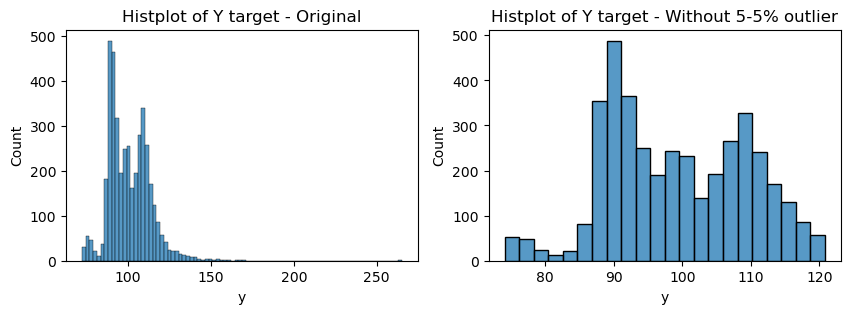

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

ax[0].set_title("Histplot of Y target - Original")
sns.histplot(data=df, x="y", ax=ax[0])

ax[1].set_title("Histplot of Y target - Without 5-5% outlier")
sns.histplot(data=df[(df.y > df.y.quantile(.005)) & (df.y < df.y.quantile(0.95))], x="y", ax=ax[1])

plt.show()

# Features with dtype int and float

In [13]:
# Object dtype cols
number_type_features = df.select_dtypes(exclude='object').iloc[:, :-1]

In [14]:
bool_cols = []
number_cols = []

In [15]:
for col in number_type_features:

    if number_type_features[col].nunique() == 2:
        bool_cols.append(col)
    else:
        number_cols.append(col)
        

In [16]:
print(f"Len of bool cols: {len(bool_cols)}, some sample: {np.random.choice(bool_cols, 3)}")
print(f"Len of number cols: {len(number_cols)}, some sample: {np.random.choice(number_cols, 3)}")

Len of bool cols: 356, some sample: ['x339' 'x355' 'x346']
Len of number cols: 12, some sample: ['x347' 'x290' 'x347']


In [17]:
number_type_features["x93"].unique()

array([0], dtype=int64)

In [18]:
number_type_features["x93"].nunique()

1

In [19]:
for col in number_cols:
    print(f"Col name: {col}, unique values within: {number_type_features[col].nunique()}")

Col name: x11, unique values within: 1
Col name: x93, unique values within: 1
Col name: x107, unique values within: 1
Col name: x233, unique values within: 1
Col name: x235, unique values within: 1
Col name: x268, unique values within: 1
Col name: x289, unique values within: 1
Col name: x290, unique values within: 1
Col name: x293, unique values within: 1
Col name: x297, unique values within: 1
Col name: x330, unique values within: 1
Col name: x347, unique values within: 1


In [20]:
# Number Cols are constant in train dataset, so maybe dropping them would be advisable!

# Features with object dtype

In [21]:
# Object dtype cols
object_type_features = df.select_dtypes(include='object')

In [22]:
object_type_features.head()

,x0,x1,x2,x3,x4,x5,x6,x8
0,k,v,at,a,d,u,j,o
1,k,t,av,e,d,y,l,o
2,az,w,n,c,d,x,j,x
3,az,t,n,f,d,x,l,e
4,az,v,n,f,d,h,d,n


In [23]:
for col in object_type_features:
    print(f"Col name: {col}, unique values within: {object_type_features[col].nunique()}, some example: {np.random.choice(object_type_features[col].unique(), 3)}")

Col name: x0, unique values within: 47, some example: ['al' 'ao' 'ai']
Col name: x1, unique values within: 27, some example: ['m' 'f' 'd']
Col name: x2, unique values within: 44, some example: ['t' 'b' 'at']
Col name: x3, unique values within: 7, some example: ['g' 'b' 'c']
Col name: x4, unique values within: 4, some example: ['c' 'd' 'c']
Col name: x5, unique values within: 29, some example: ['f' 'f' 'o']
Col name: x6, unique values within: 12, some example: ['a' 'j' 'g']
Col name: x8, unique values within: 25, some example: ['w' 'a' 'v']


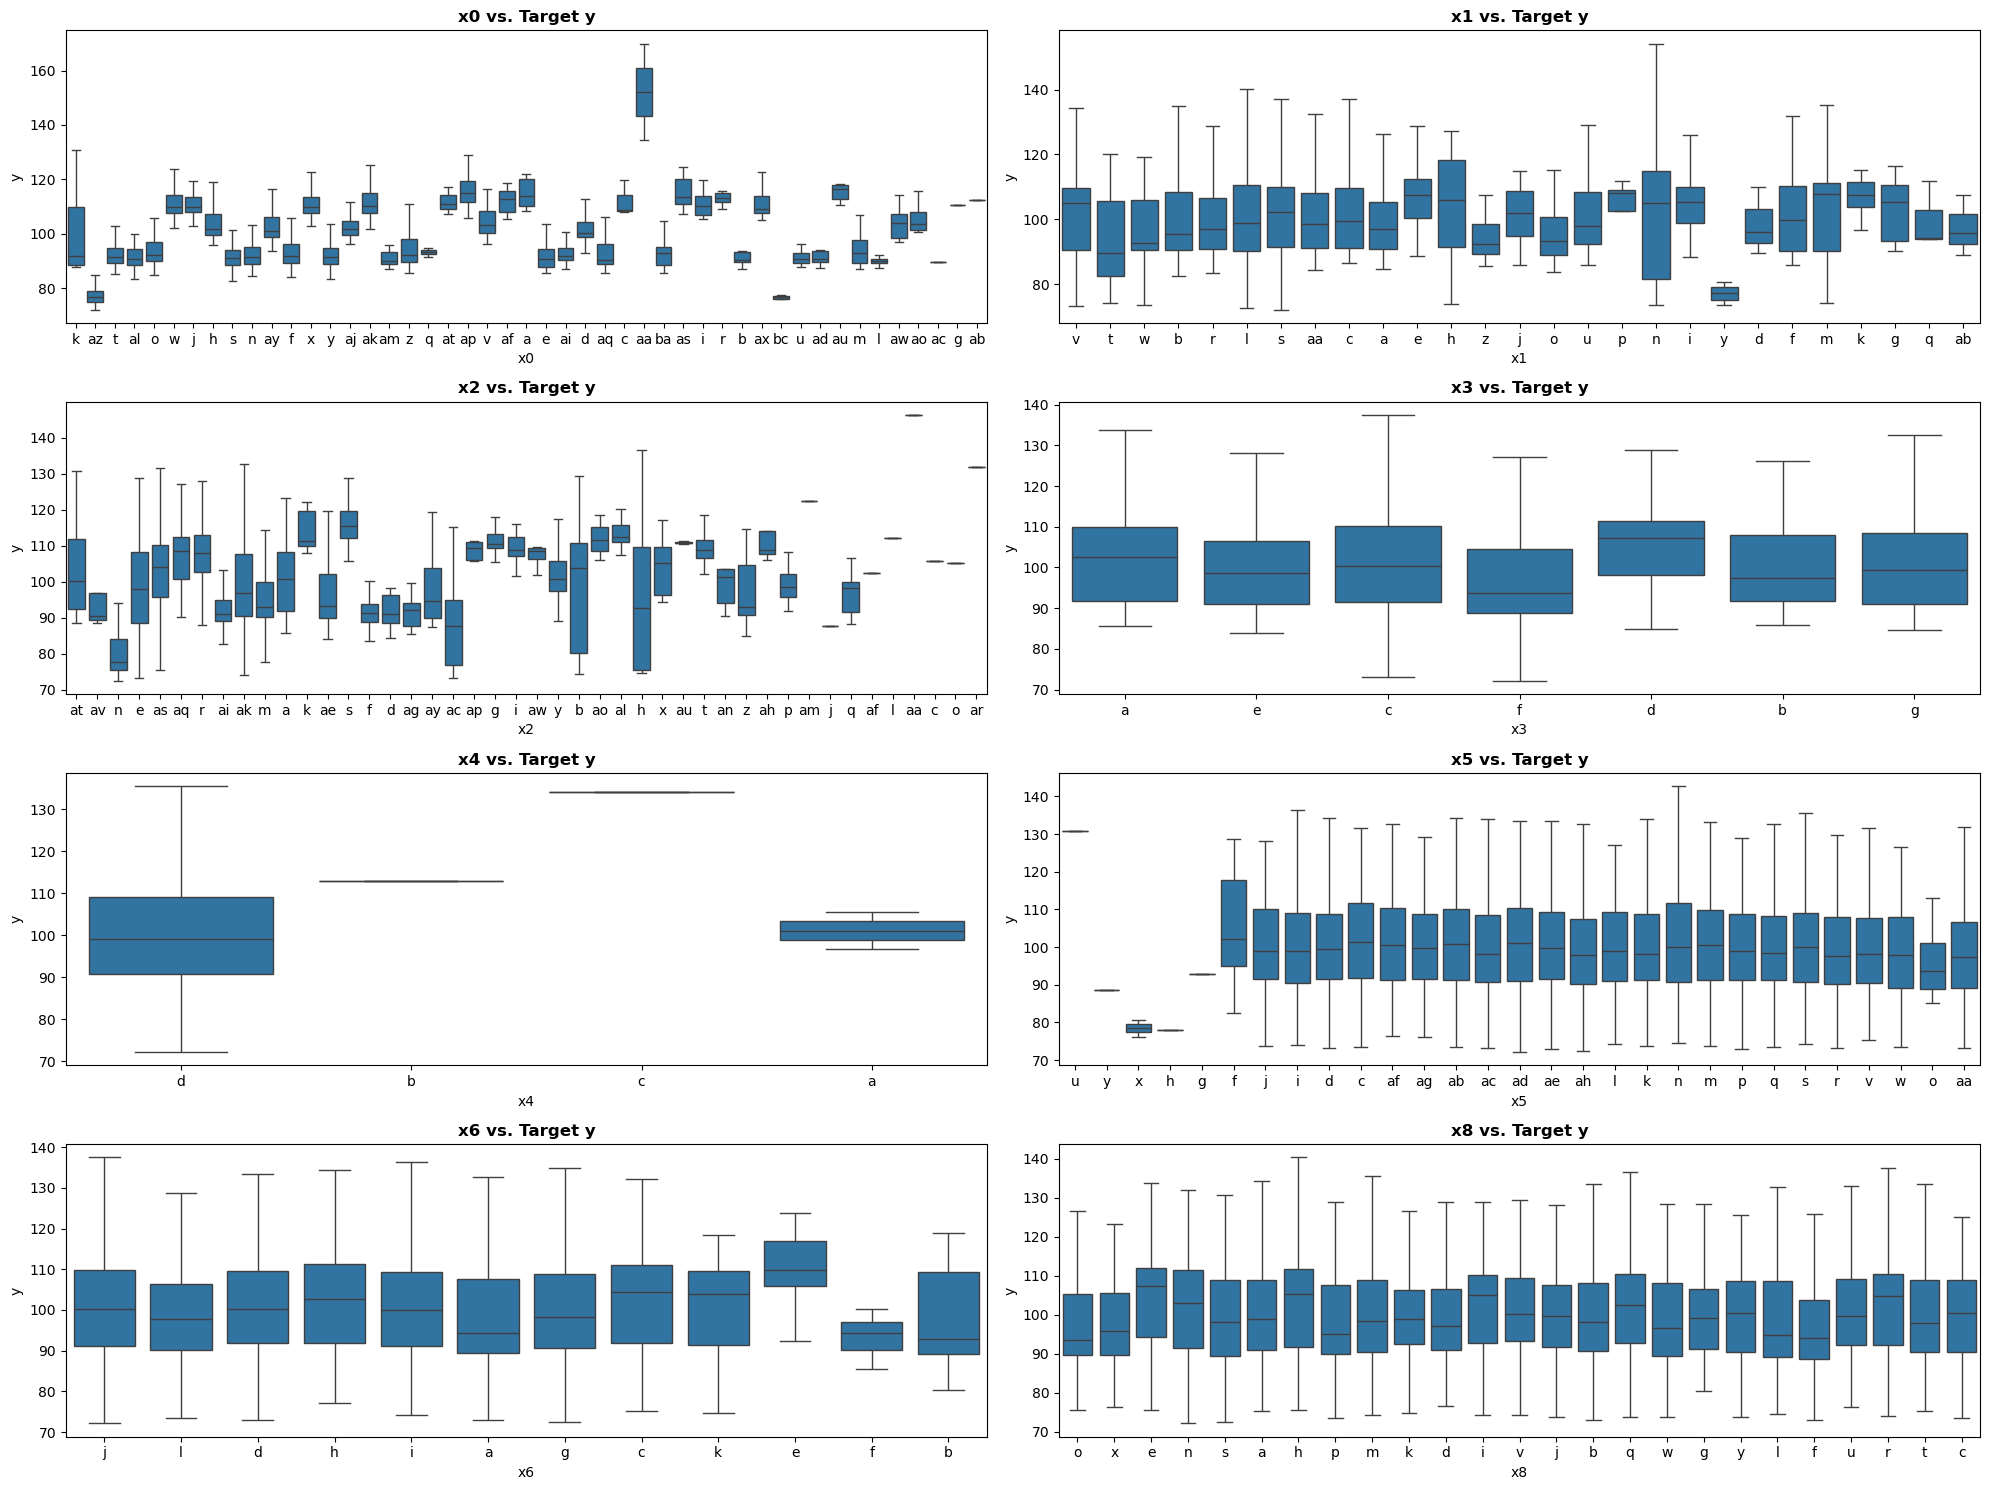

In [24]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(20, 15))

ax = ax.flatten()
object_type_features_with_y = pd.concat([object_type_features, df[["y"]]], axis=1)

for i, feature in enumerate(object_type_features):
    sns.boxplot(data=object_type_features_with_y, x=feature, y="y", ax=ax[i], showfliers=False)
    ax[i].set_title(f"{feature} vs. Target y", fontweight="bold")

plt.tight_layout()
plt.show()

### Dropping number cols (constant cols), and one-hot encode categorical features

In [25]:
df.drop(number_cols, axis=1, inplace=True)

In [26]:
df = df.to_numpy()

In [27]:
df_backup = df.copy()

In [28]:
df[:, :8]

array([['k', 'v', 'at', ..., 'u', 'j', 'o'],
       ['k', 't', 'av', ..., 'y', 'l', 'o'],
       ['az', 'w', 'n', ..., 'x', 'j', 'x'],
       ...,
       ['ak', 'v', 'r', ..., 'aa', 'g', 'e'],
       ['al', 'r', 'e', ..., 'aa', 'l', 'u'],
       ['z', 'r', 'ae', ..., 'aa', 'g', 'w']], dtype=object)

In [29]:
df[:, :8] = df[:, :8].astype(str)

In [30]:
X = df[:, :-1]
y = df[:, -1]

In [31]:
categorical_features = X[:, :8]
numerical_features = X[:, 8:]

## Correlation

In [32]:
concatted_df = np.concatenate([numerical_features, y.reshape(-1, 1)], axis=1)

In [33]:
concatted_df = concatted_df.astype("float32")

In [34]:
concatted_df = pd.DataFrame(concatted_df, columns=[f'Feature_{i}' for i in range(concatted_df.shape[1]-1)] + ["y"])
correlation_matrix = concatted_df.corr()

In [35]:
correlation_matrix["y"].abs().sort_values(ascending=False)[1:26] #remove self correlation

Feature_287    0.606005
Feature_240    0.588785
Feature_111    0.510620
Feature_257    0.379629
Feature_17     0.379629
Feature_213    0.379629
Feature_242    0.379629
Feature_63     0.368177
Feature_42     0.368177
Feature_120    0.368177
Feature_301    0.366220
Feature_254    0.359254
Feature_145    0.355876
Feature_250    0.350868
Feature_286    0.330960
Feature_149    0.330925
Feature_229    0.298779
Feature_161    0.287024
Feature_253    0.275042
Feature_103    0.272728
Feature_104    0.272728
Feature_289    0.259919
Feature_349    0.258679
Feature_214    0.258604
Feature_16     0.250288
Name: y, dtype: float64

In [36]:
concatted_df.shape

(4209, 357)

## Findings

TODO


# Single Layer Perceptron = Linear Regression in Current Situation

Creating custom Models

In [37]:
keras.utils.get_custom_objects().clear()

In [38]:
@keras.utils.register_keras_serializable()
class SLP(tf.keras.Model):
    def __init__(self, input_dim, output_dim, seed=42):
        super(SLP, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        initializer = tf.keras.initializers.GlorotUniform(seed=seed)

        self.W = self.add_weight(name="W_weights", shape=(input_dim, output_dim),
                                 initializer=initializer,
                                 trainable=True)
        self.b = self.add_weight(name="B_biases", shape=(output_dim,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs):
        logits = tf.matmul(inputs, self.W) + self.b
        return logits

    def get_config(self):
        return {
            "input_dim": self.input_dim,
            "output_dim": self.output_dim,
            "seed": 42  
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [39]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [40]:
y = y.reshape(-1, 1)
X_tensor = tf.convert_to_tensor(concatted_df.iloc[:, :-1], dtype=tf.float32)
y_tensor = tf.convert_to_tensor(y, dtype=tf.float32)

In [ ]:
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [16, 32, 64]
epochs_list = [50, 150]

params = []
root_mean_squared_errors_list = []


for lr in learning_rates:
    for bs in batch_sizes:
        for epochs in epochs_list:
            rmse_current_config = []

            for (train_idx, val_idx) in kfold.split(X_tensor, y_tensor):
                
                X_train, y_train = tf.gather(X_tensor, train_idx), tf.gather(y_tensor, train_idx)
                X_val, y_val = tf.gather(X_tensor, val_idx), tf.gather(y_tensor, val_idx)

                categorical_features_train = categorical_features[train_idx]
                categorical_features_val = categorical_features[val_idx]

                lookup_layers = categorical_to_onehot_lookups(categorical_features_train)
                X_train_categorical = lookups_for_one_hot(categorical_features_train, lookup_layers)
                X_val_categorical = lookups_for_one_hot(categorical_features_val, lookup_layers)

                X_train = tf.concat([X_train_categorical, X_train], axis=1)
                X_val = tf.concat([X_val_categorical, X_val], axis=1)   

                slp_model = SLP(X_train.shape[1], y_train.shape[1])
                slp_model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr), loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

                slp_model.fit(X_train, y_train, epochs=epochs, batch_size=bs, verbose=2)

                val_predictions = slp_model.predict(X_val)

                val_rmse = root_mean_squared_error(y_val.numpy(), val_predictions)
                rmse_current_config.append(val_rmse)

                K.clear_session()

            root_mean_squared_errors_list.append(rmse_current_config)
            params.append([lr, bs, epochs])


In [87]:
best_params = params[np.argmin(np.mean(np.array(root_mean_squared_errors_list), axis=1))]

In [41]:
best_params = [0.001, 16, 150]

In [42]:
K.clear_session()

In [134]:
train_idx =  [index for index in range(0, round(len(X)*0.8))]
val_idx = [index for index in range(round(len(X)*0.8), len(X))]
# Test on last 0.2 fraction

X_train, y_train = tf.gather(X_tensor, train_idx), tf.gather(y_tensor, train_idx)
X_val, y_val = tf.gather(X_tensor, val_idx), tf.gather(y_tensor, val_idx)

categorical_features_train = categorical_features[train_idx]
categorical_features_val = categorical_features[val_idx]

lookup_layers = categorical_to_onehot_lookups(categorical_features_train)
X_train_categorical = lookups_for_one_hot(categorical_features_train, lookup_layers)
X_val_categorical = lookups_for_one_hot(categorical_features_val, lookup_layers)

X_train = tf.concat([X_train_categorical, X_train], axis=1)
X_val = tf.concat([X_val_categorical, X_val], axis=1)   

slp_model = SLP(X_train.shape[1], y_train.shape[1])
slp_model.compile(optimizer=tf.optimizers.Adam(learning_rate=best_params[0]), loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

slp_model.fit(X_train, y_train, epochs=best_params[2], batch_size=best_params[1], verbose=2)

val_predictions = slp_model.predict(X_val)


Epoch 1/150
211/211 - 1s - loss: 9212.5312 - root_mean_squared_error: 95.9819 - 990ms/epoch - 5ms/step
Epoch 2/150
211/211 - 1s - loss: 7024.9854 - root_mean_squared_error: 83.8152 - 744ms/epoch - 4ms/step
Epoch 3/150
211/211 - 1s - loss: 5263.3765 - root_mean_squared_error: 72.5491 - 596ms/epoch - 3ms/step
Epoch 4/150
211/211 - 1s - loss: 3871.1060 - root_mean_squared_error: 62.2182 - 707ms/epoch - 3ms/step
Epoch 5/150
211/211 - 1s - loss: 2794.4106 - root_mean_squared_error: 52.8622 - 766ms/epoch - 4ms/step
Epoch 6/150
211/211 - 1s - loss: 1982.2029 - root_mean_squared_error: 44.5219 - 600ms/epoch - 3ms/step
Epoch 7/150
211/211 - 1s - loss: 1387.2106 - root_mean_squared_error: 37.2453 - 650ms/epoch - 3ms/step
Epoch 8/150
211/211 - 1s - loss: 965.2847 - root_mean_squared_error: 31.0690 - 812ms/epoch - 4ms/step
Epoch 9/150
211/211 - 1s - loss: 677.5295 - root_mean_squared_error: 26.0294 - 602ms/epoch - 3ms/step
Epoch 10/150
211/211 - 1s - loss: 490.3742 - root_mean_squared_error: 22.14

In [135]:
print(f"RMSE: {root_mean_squared_error(y_val.numpy(), val_predictions)}, R2: {r2_score(y_val.numpy(), val_predictions)}")

RMSE: 6.909861087799072, R2: 0.6380504369735718


In [43]:
def get_model(X_train, y_tensor):
    slp_model = SLP(X_train.shape[1], y_tensor.shape[1])
    slp_model.compile(optimizer=tf.optimizers.Adam(learning_rate=best_params[0]), loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return slp_model

In [44]:
lookup_layers = categorical_to_onehot_lookups(categorical_features)
X_train_categorical = lookups_for_one_hot(categorical_features, lookup_layers)

X_train = tf.concat([X_train_categorical, X_tensor], axis=1)

slp_model = get_model(X_train, y_tensor)
slp_model.fit(X_train, y_tensor, epochs=best_params[2], batch_size=best_params[1], verbose=2)


Epoch 1/150
264/264 - 2s - loss: 8844.2236 - root_mean_squared_error: 94.0437 - 2s/epoch - 8ms/step
Epoch 2/150
264/264 - 1s - loss: 6265.2759 - root_mean_squared_error: 79.1535 - 821ms/epoch - 3ms/step
Epoch 3/150
264/264 - 1s - loss: 4318.8237 - root_mean_squared_error: 65.7178 - 660ms/epoch - 3ms/step
Epoch 4/150
264/264 - 1s - loss: 2891.0359 - root_mean_squared_error: 53.7684 - 736ms/epoch - 3ms/step
Epoch 5/150
264/264 - 1s - loss: 1882.4603 - root_mean_squared_error: 43.3873 - 785ms/epoch - 3ms/step
Epoch 6/150
264/264 - 1s - loss: 1201.7526 - root_mean_squared_error: 34.6663 - 796ms/epoch - 3ms/step
Epoch 7/150
264/264 - 1s - loss: 766.2113 - root_mean_squared_error: 27.6805 - 724ms/epoch - 3ms/step
Epoch 8/150
264/264 - 1s - loss: 504.7746 - root_mean_squared_error: 22.4672 - 762ms/epoch - 3ms/step
Epoch 9/150
264/264 - 1s - loss: 359.6337 - root_mean_squared_error: 18.9640 - 744ms/epoch - 3ms/step
Epoch 10/150
264/264 - 1s - loss: 282.9143 - root_mean_squared_error: 16.8201 -

In [189]:
slp_model.save("model")

INFO:tensorflow:Assets written to: model\assets


In [48]:
for i, lookup_layer in enumerate(lookup_layers):
    vocab = lookup_layer.get_vocabulary()
    with open(f"vocabularies/string_lookup_vocab_{i}.txt", "w") as f:
        for item in vocab:
            f.write(f"{item}\n")

# MLP


In [5]:
df = pd.read_csv("train/train.csv")

In [6]:
df.columns = [col.lower() for col in df]
df.drop("id", axis=1, inplace=True)

In [7]:
df = df[df.select_dtypes(include="object").columns.to_list() + df.select_dtypes(exclude="object").columns.to_list()]
df = df[df.drop("y", axis=1).columns.to_list() + ["y"]]

In [8]:
cols_to_drop = ['x11', 'x93', 'x107', 'x233', 'x235', 'x268', 'x289', 'x290', 'x293', 'x297', 'x330', 'x347']

In [9]:
df.drop(cols_to_drop, axis=1, inplace=True)
df = df.to_numpy()
df[:, :8] = df[:, :8].astype(str)

In [10]:
categorical_features = df[:, :8].astype(str) 
numerical_features = tf.convert_to_tensor(df[:, 8:-1].astype("float32"))
target_y = tf.convert_to_tensor(df[:, -1].astype("float32"))

In [11]:
def create_combined_model(X_train_shape, hidden_layers=None):
    
    input_layer = tf.keras.layers.Input(shape=(X_train_shape,), name='input_layer')

    last_hidden_layer = input_layer 
    
    for hidden_layer_attribute in hidden_layers: #node or dropout percent
        if isinstance(hidden_layer_attribute, int):
             # Dense Layer
            last_hidden_layer = tf.keras.layers.Dense(hidden_layer_attribute, activation='relu')(last_hidden_layer)
        else:
             # Dropout Layer
            last_hidden_layer = tf.keras.layers.Dropout(rate=hidden_layer_attribute)(last_hidden_layer)

    main_output = tf.keras.layers.Dense(1)(last_hidden_layer)
    
    combined_model = tf.keras.Model(inputs=input_layer, outputs=main_output)
    
    return combined_model

In [12]:
learning_rates = [0.0001, 0.001]
batch_sizes = [16, 32]
epochs_list = [50, 150]
hidden_layers_list = [(32, 0.1, 16), (64, 0.2, 32), (128, 0.2, 32), (256, 0.3, 64)]

param_grid = list(itertools.product(hidden_layers_list, learning_rates, batch_sizes, epochs_list))

In [15]:
def evaluate_model(categorical_features, numerical_features, target_y, model_params, pca_version=False):
    rmse_list = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in kfold.split(numerical_features, target_y):

        categorical_features_train, categorical_features_val =  categorical_features[train_idx],  categorical_features[val_idx]
        numerical_features_train, numerical_features_val =  tf.gather(numerical_features, train_idx), tf.gather(numerical_features, val_idx)
        target_y_train, target_y_val  = tf.gather(target_y, train_idx), tf.gather(target_y, val_idx)

        if pca_version:
            hidden_layers, lr, bs, epochs, pca_components = model_params
        else:
            hidden_layers, lr, bs, epochs = model_params

        lookup_layers = categorical_to_onehot_lookups(categorical_features_train)
        X_train_categorical = lookups_for_one_hot(categorical_features_train, lookup_layers)
        X_val_categorical = lookups_for_one_hot(categorical_features_val, lookup_layers)

        X_train = tf.concat([X_train_categorical, numerical_features_train], axis=1)
        X_val = tf.concat([X_val_categorical, numerical_features_val], axis=1)  

        pca_object = PCA(n_components=pca_components, random_state=42)

        X_train = pca_object.fit_transform(X_train)
        X_val = pca_object.transform(X_val)

        combined_model = create_combined_model(X_train.shape[1], hidden_layers=hidden_layers)

        combined_model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr), 
                            loss='mean_squared_error', 
                            metrics=[tf.keras.metrics.RootMeanSquaredError()])

        combined_model.fit(X_train, target_y_train, epochs=epochs, batch_size=bs,
                            validation_data=(X_val, target_y_val), verbose=2)

        val_predictions = combined_model.predict(X_val)

        val_rmse = root_mean_squared_error(target_y_val, val_predictions)
        rmse_list.append(val_rmse)

        K.clear_session()
    
    return {model_params: sum(rmse_list) / len(rmse_list)} #return a dict



In [ ]:
root_mean_squared_errors_list = [evaluate_model(categorical_features, numerical_features, target_y, params, pca_version=False) for params in param_grid]


In [ ]:
root_mean_squared_errors_list

In [16]:
result = {}
for d in root_mean_squared_errors_list:
    result.update(d)

In [17]:
best_params = ((32, 0.1, 16), 0.0001, 16, 50)

# Trying PCA

In [16]:
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [16, 32]
epochs_list = [50, 150]
hidden_layers_list = [(32, 0.1, 16), (32, 16), (64, 0.1, 32)]
pca_components = [50, 150, 250]

param_grid = list(itertools.product(hidden_layers_list, learning_rates, batch_sizes, epochs_list, pca_components))

In [ ]:
root_mean_squared_errors_list = []
for params in param_grid:
    root_mean_squared_errors_list.append(evaluate_model(categorical_features, numerical_features, target_y, params, pca_version=True))


In [18]:
result = {}
for d in root_mean_squared_errors_list:
    result.update(d)

In [ ]:
sorted(result.items(), key=lambda x:x[1])

In [21]:
best_params = ((32, 0.1, 16), 0.001, 32, 150, 50)

In [23]:
hidden_layers, lr, bs, epochs, pca_components = best_params

In [29]:
K.clear_session()

In [38]:
train_idx =  [index for index in range(0, round(len(numerical_features)*0.8))]
val_idx = [index for index in range(round(len(numerical_features)*0.8), len(numerical_features))]

categorical_features_train, categorical_features_val =  categorical_features[train_idx],  categorical_features[val_idx]
numerical_features_train, numerical_features_val =  tf.gather(numerical_features, train_idx), tf.gather(numerical_features, val_idx)
target_y_train, target_y_val  = tf.gather(target_y, train_idx), tf.gather(target_y, val_idx)

lookup_layers = categorical_to_onehot_lookups(categorical_features_train)
X_train_categorical = lookups_for_one_hot(categorical_features_train, lookup_layers)
X_val_categorical = lookups_for_one_hot(categorical_features_val, lookup_layers)

X_train = tf.concat([X_train_categorical, numerical_features_train], axis=1)
X_val = tf.concat([X_val_categorical, numerical_features_val], axis=1)  

pca_object = PCA(n_components=pca_components, random_state=42)

X_train = pca_object.fit_transform(X_train)
X_val = pca_object.transform(X_val)

combined_model = create_combined_model(X_train.shape[1], hidden_layers=hidden_layers)

combined_model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr), 
                    loss='mean_squared_error', 
                    metrics=[tf.keras.metrics.RootMeanSquaredError()])

combined_model.fit(X_train, target_y_train, epochs=epochs, batch_size=bs,
                    validation_data=(X_val, target_y_val), verbose=2)

val_predictions = combined_model.predict(X_val)

Epoch 1/150
106/106 - 1s - loss: 10084.8740 - root_mean_squared_error: 100.4235 - val_loss: 9012.0068 - val_root_mean_squared_error: 94.9316 - 1s/epoch - 11ms/step
Epoch 2/150
106/106 - 1s - loss: 7793.3257 - root_mean_squared_error: 88.2798 - val_loss: 5141.5742 - val_root_mean_squared_error: 71.7048 - 533ms/epoch - 5ms/step
Epoch 3/150
106/106 - 0s - loss: 2957.5813 - root_mean_squared_error: 54.3836 - val_loss: 744.6846 - val_root_mean_squared_error: 27.2889 - 468ms/epoch - 4ms/step
Epoch 4/150
106/106 - 0s - loss: 420.1089 - root_mean_squared_error: 20.4966 - val_loss: 118.0076 - val_root_mean_squared_error: 10.8631 - 486ms/epoch - 5ms/step
Epoch 5/150
106/106 - 1s - loss: 216.0614 - root_mean_squared_error: 14.6990 - val_loss: 94.3376 - val_root_mean_squared_error: 9.7128 - 566ms/epoch - 5ms/step
Epoch 6/150
106/106 - 0s - loss: 199.1735 - root_mean_squared_error: 14.1129 - val_loss: 86.0598 - val_root_mean_squared_error: 9.2768 - 482ms/epoch - 5ms/step
Epoch 7/150
106/106 - 1s - 

In [40]:
print(f"RMSE: {root_mean_squared_error(target_y_val, val_predictions)}")

RMSE: 7.3365068435668945


In [42]:
print(f"RMSE: {root_mean_squared_error(target_y_val.numpy(), val_predictions)}, R2: {r2_score(target_y_val.numpy(), val_predictions)}")

RMSE: 7.3365068435668945, R2: 0.5919737219810486
